/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


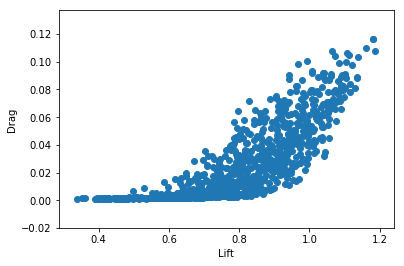

In [1]:
import sys
sys.path.append('../python')
import time
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt



import numpy as np

qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))

plt.scatter(forces[:,1], forces[:,2])
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.show()

N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]

permuted_indices = range(N)#np.random.permutation(N)
qmc_points=qmc_points[permuted_indices,:]
forces = forces[permuted_indices,:]
input_size=6
force_component = 1
train_size=128
validation_size=200



In [2]:
def get_network(parameters, data, *,train_size, validation_size, batch_size, title):
    model = Sequential([
        Dense(10, input_shape=(input_size,)),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(1)
    ])
    
    
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size]
    epochs=500000
    
    training_start_time=time.time()
    hist = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,shuffle=True, 
                     validation_data=(x_val, y_val),verbose=0)
    training_end_time=time.time()
    print("Training took {} seconds".format (training_end_time-training_start_time))
    
    epochs_r=range(1, epochs)
    plt.loglog(hist.history['loss'])
    plt.title('Training loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('training_loss')
    
    plt.loglog(hist.history['val_loss'])
    plt.title('Validation loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('validation_loss')
    x_test =  parameters[validation_size+train_size:,:]
    y_test = data[train_size+validation_size:]
    y_predict = model.predict(x_test)
    
    plt.title('Scatter comparision (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.scatter(y_test, y_predict)
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    showAndSave("scatter_comparison")
    print(model.summary())
    
   
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    coeffs = reg.fit(parameters[:train_size,:], y_train)
    
    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Linear Least squares (%d samples)' % (train_size))
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    showAndSave("scatter_lsq_comparision")
    
    
    def myvar(x):
        mean = np.sum(x)/x.shape[0]
        var = np.sum((mean-x)**2)/x.shape[0]
        return var
        
    def mymean (x): 
        return np.sum(x)/x.shape[0]
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = model.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data - predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml/2.))
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = np.mean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = np.mean(model.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = np.mean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    predicted_all = model.predict(all_points)
    predicted_all = predicted_all.reshape(all_points.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = np.var(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = np.var(model.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = np.var(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    
    
   
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.title("Comparison QMC and Machine learning\n%s\nepochs=%d,batch_size=%d"% (title, epochs,batch_size))
    plt.hist(model.predict(parameters),bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml')
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples\n%s" %(parameters.shape[0], train_size, title))
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc')
    
    plt.title("Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % train_size,alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq')
    
    
    
    
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.title("(coarse hist) Comparison QMC and Machine learning\n%s\nepochs=%d,batch_size=%d"% (title, epochs,batch_size))
    plt.hist(model.predict(parameters),bins=20,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml_coarse')
    
    
    plt.title("(coarse hist) Comparison QMC with %d and QMC with %d samples\n%s" %(parameters.shape[0], train_size, title))
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.hist(data[:train_size],bins=20,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc_coarse')
    
    plt.title("(coarse hist) Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % train_size,alpha=0.5)
    plt.hist(evaluated_lsq,bins=20,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq_coarse')
    
    return model

# One network per variable

Training took 6846.212324857712 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


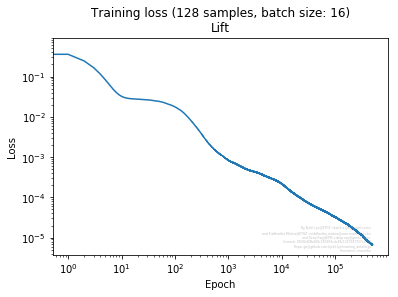

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


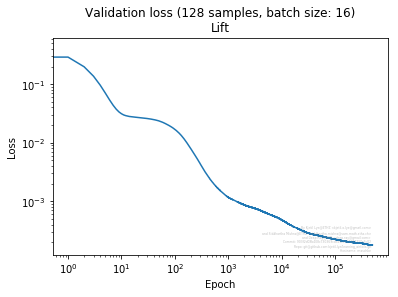

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


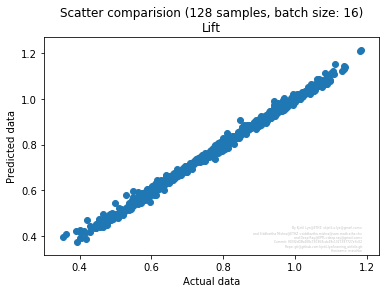

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                70        
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                132       
_________________________________________________________________
activation_2 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                130       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                132       
__________

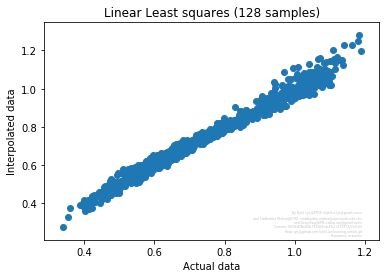

variance single level = 0.031350
variance diff ml = 0.000149 
speedup = 105.091007
(1001,)
variance_diff_interpolate = 0.000684
mean_qmc = 0.770562
mean_ml = 0.770753
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.771482
var_qmc = 0.031350
var_ml = 0.031469
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


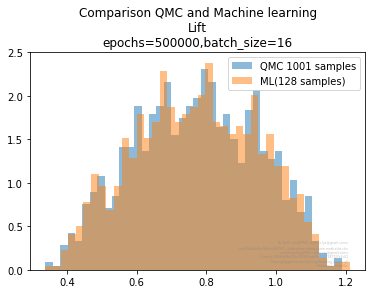

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


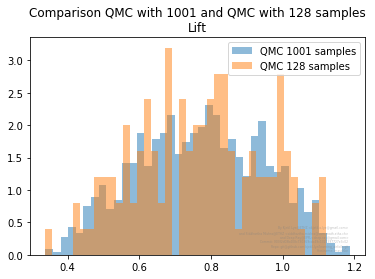

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


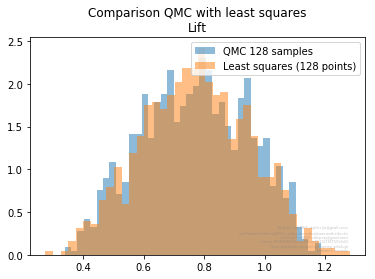

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


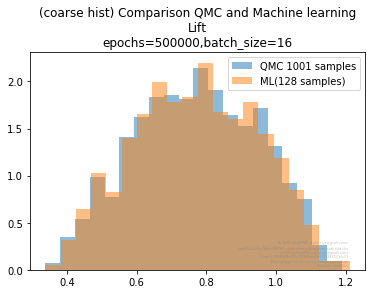

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


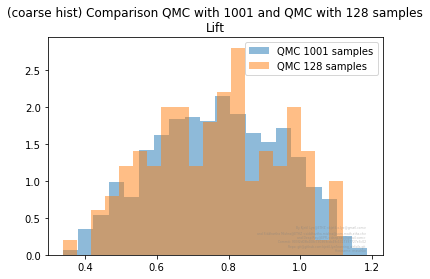

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


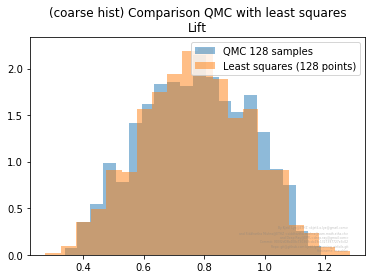

Training took 7026.187086582184 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


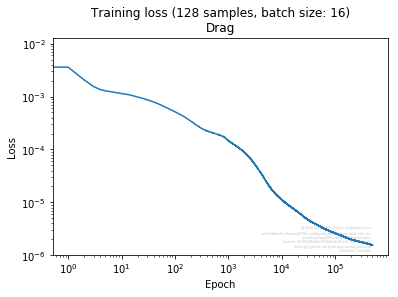

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


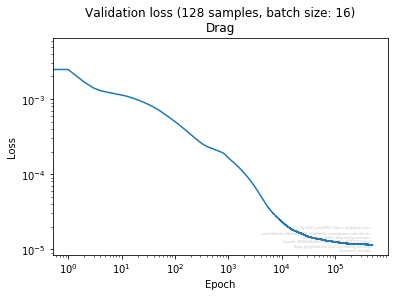

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


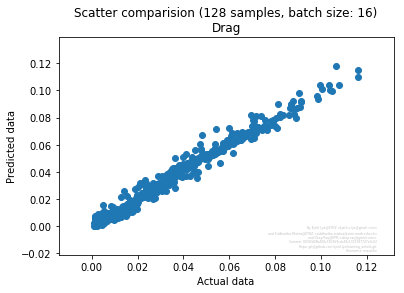

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                70        
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                132       
_________________________________________________________________
activation_8 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_9 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                132       
__________

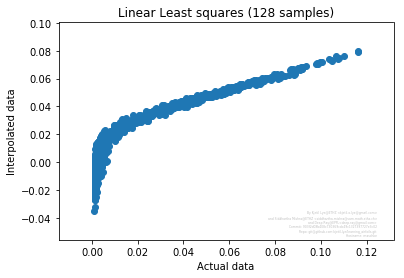

variance single level = 0.000701
variance diff ml = 0.000010 
speedup = 35.389568
(1001,)
variance_diff_interpolate = 0.000131
mean_qmc = 0.023544
mean_ml = 0.023972
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.024004
var_qmc = 0.000701
var_ml = 0.000713
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


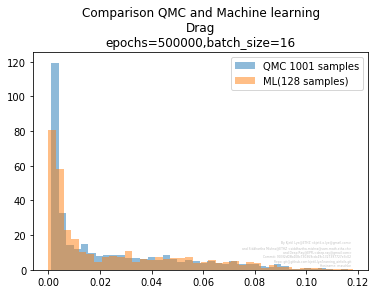

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


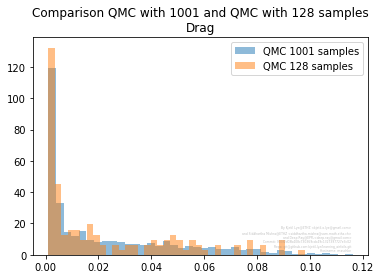

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


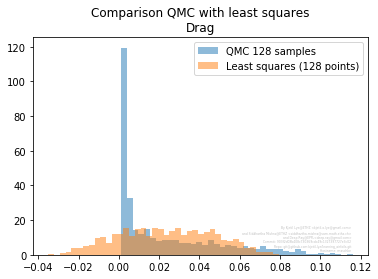

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


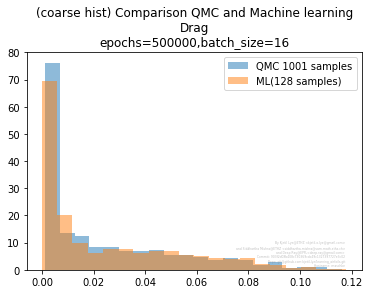

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


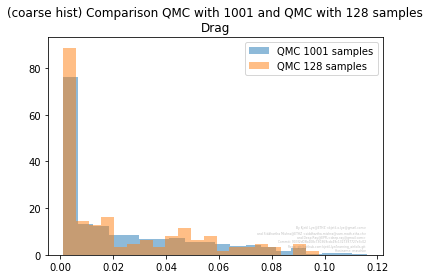

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


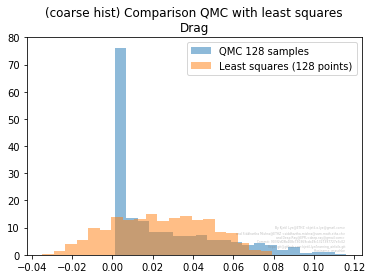

Training took 3683.951680660248 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


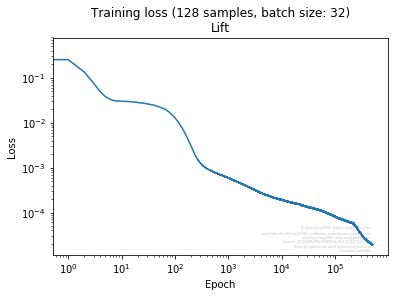

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


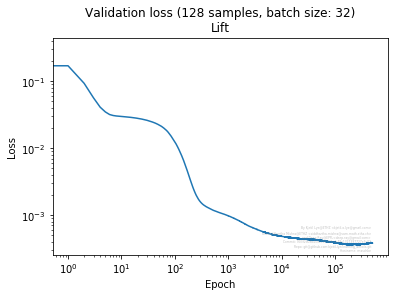

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


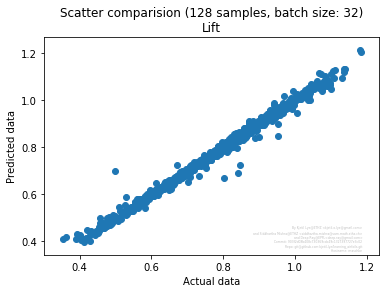

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_13 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_14 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_15 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 12)                132       
__________

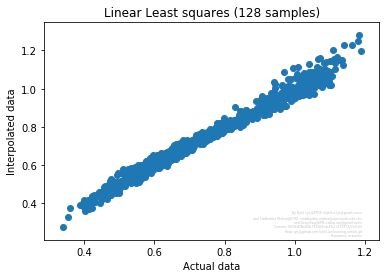

variance single level = 0.031350
variance diff ml = 0.000339 
speedup = 46.231653
(1001,)
variance_diff_interpolate = 0.000684
mean_qmc = 0.770562
mean_ml = 0.769242
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.769658
var_qmc = 0.031350
var_ml = 0.031330
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


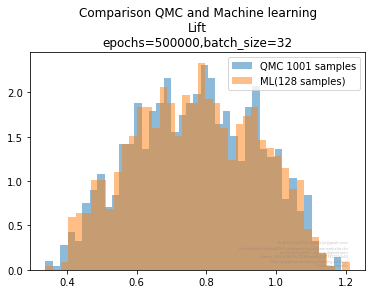

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


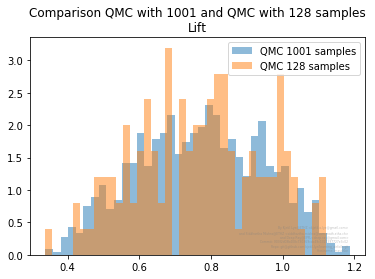

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


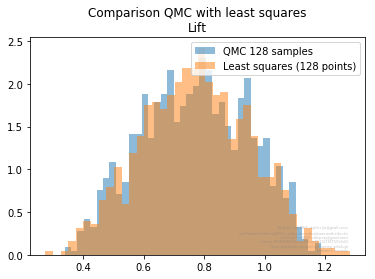

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


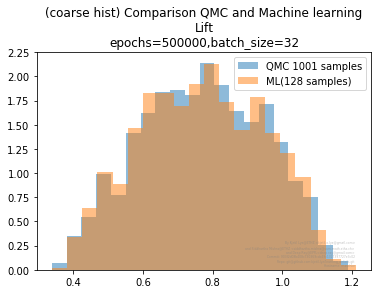

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


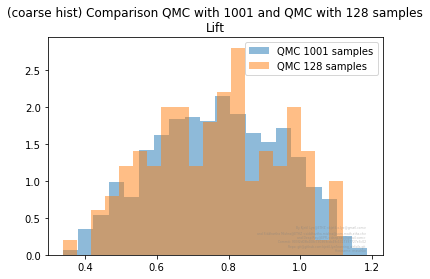

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


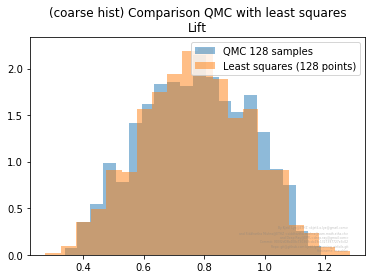

Training took 3803.8900814056396 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


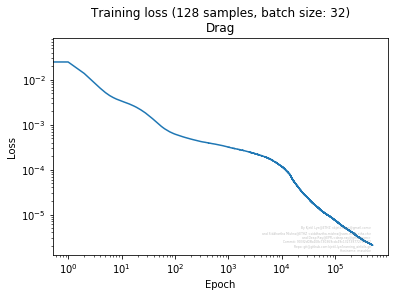

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


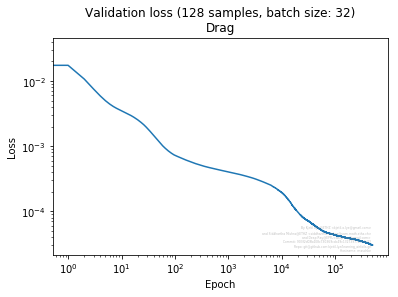

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


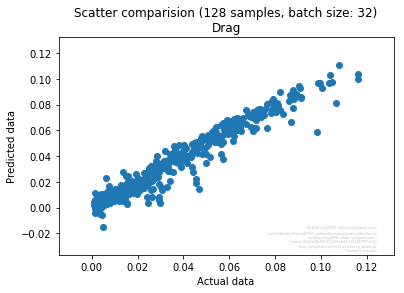

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_19 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_20 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_21 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 12)                132       
__________

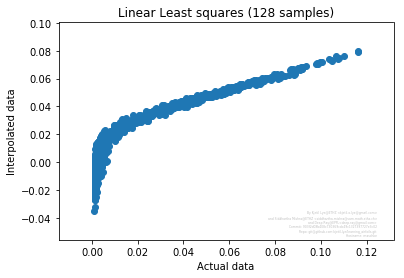

variance single level = 0.000701
variance diff ml = 0.000027 
speedup = 13.132725
(1001,)
variance_diff_interpolate = 0.000131
mean_qmc = 0.023544
mean_ml = 0.023050
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.022941
var_qmc = 0.000701
var_ml = 0.000671
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


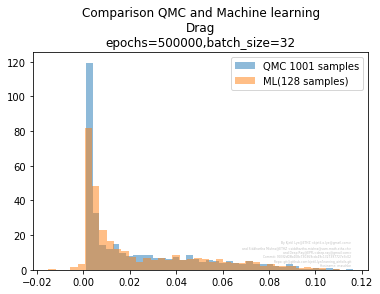

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


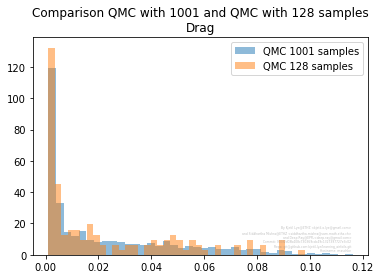

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


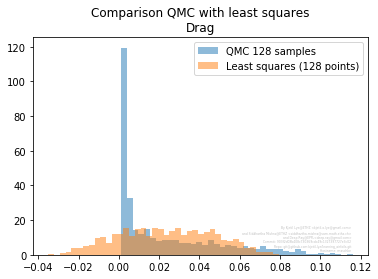

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


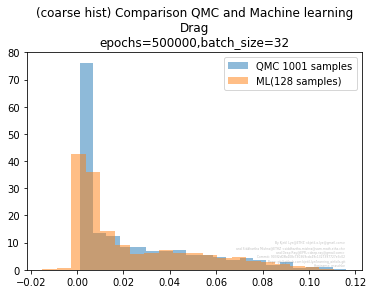

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


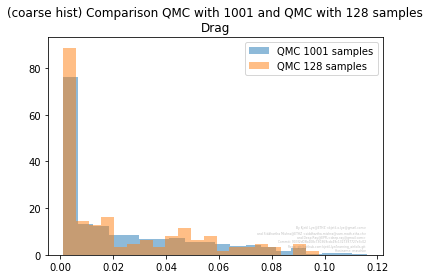

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


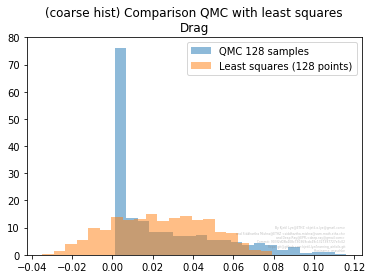

Training took 1191.6695671081543 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


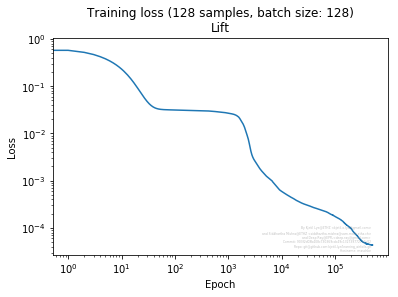

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


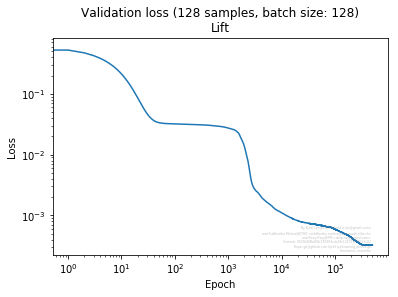

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


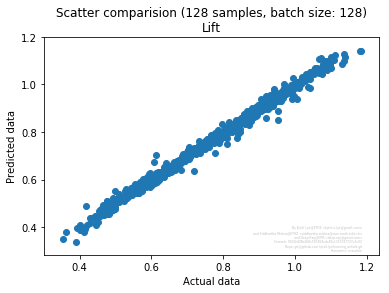

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_25 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_26 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_27 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 12)                132       
__________

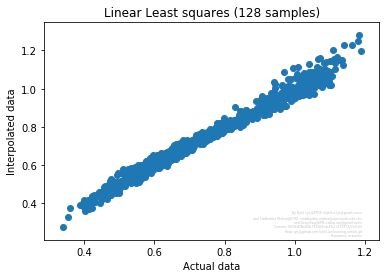

variance single level = 0.031350
variance diff ml = 0.000267 
speedup = 58.739808
(1001,)
variance_diff_interpolate = 0.000684
mean_qmc = 0.770562
mean_ml = 0.768149
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.769122
var_qmc = 0.031350
var_ml = 0.030866
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


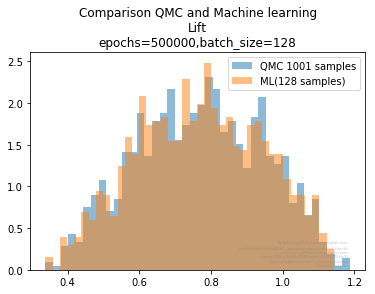

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


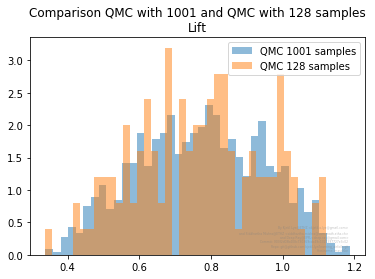

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


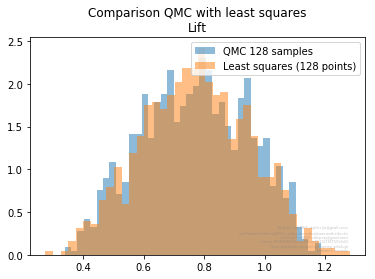

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


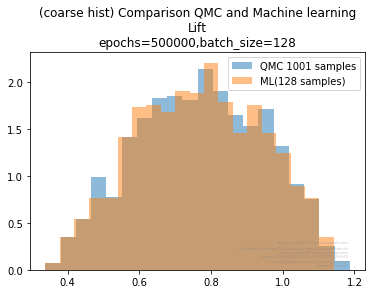

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


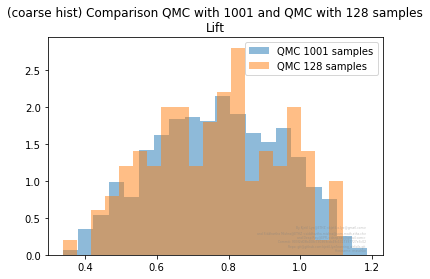

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


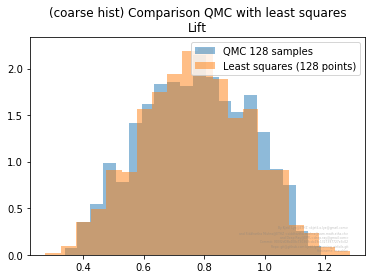

Training took 1225.875480413437 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


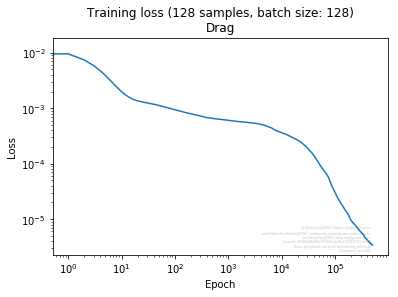

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


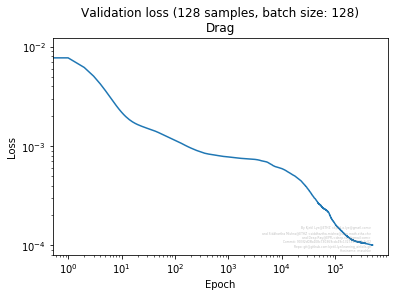

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


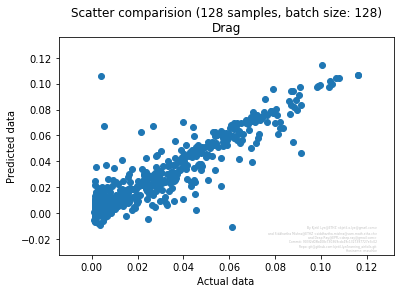

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_31 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_32 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_33 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 12)                132       
__________

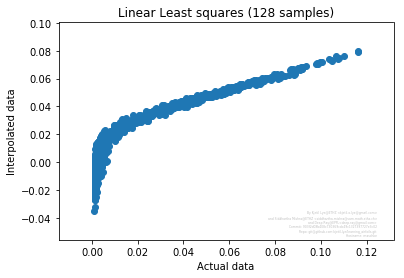

variance single level = 0.000701
variance diff ml = 0.000088 
speedup = 3.968579
(1001,)
variance_diff_interpolate = 0.000131
mean_qmc = 0.023544
mean_ml = 0.023202
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.022971
var_qmc = 0.000701
var_ml = 0.000676
var_few_qmc = 0.083328
(1001, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


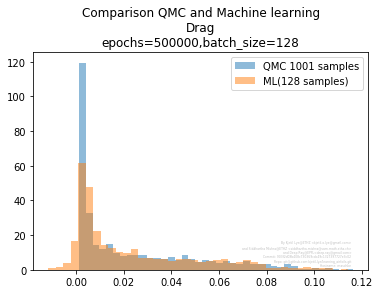

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


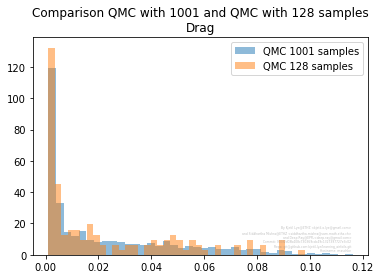

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


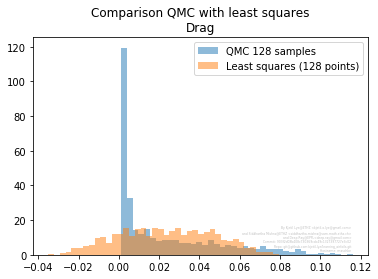

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


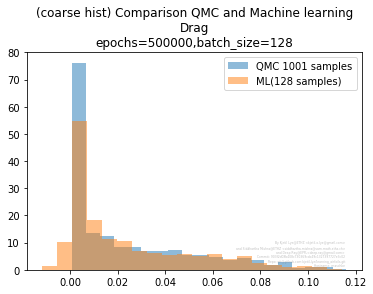

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


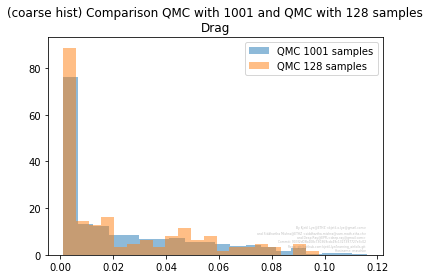

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


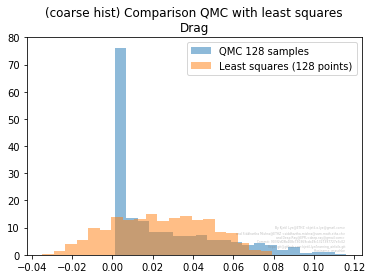

In [3]:
force_names=['Lift', 'Drag']
batch_sizes=[16, 32, train_size]

for batch_size in batch_sizes:
    for (n, f) in enumerate(force_names):
        showAndSave.prefix='airfoil_%s_ts_%d_bs_%d' %(f,batch_size, train_size)
        network= get_network(qmc_points, forces[:,n+1], train_size=train_size, validation_size=validation_size,
                        batch_size=batch_size, title=f)
    
    



# One network to rule them all

In [10]:
def get_network_dual(parameters, data, *,train_size, validation_size, batch_size, title, names):
    model = Sequential([
        Dense(10, input_shape=(input_size,)),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(data.shape[1])
    ])
    
    
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
    y_train=data[:train_size,:]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size,:]
    epochs=500000
    
    training_start_time=time.time()
    hist = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,shuffle=True, 
                     validation_data=(x_val, y_val),verbose=0)
    training_end_time=time.time()
    print("Training took {} seconds".format (training_end_time-training_start_time))
    
    epochs_r=range(1, epochs)
    plt.loglog(hist.history['loss'])
    plt.title('Training loss (%d samples, batch size: %d, output_size: %d)\n%s' %(train_size, batch_size, data.shape[1], title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('training_loss_dual')
    
    plt.loglog(hist.history['val_loss'])
    plt.title('Validation loss (%d samples, batch size: %d, output_size: %d)\n%s' %(train_size, batch_size, data.shape[1], title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('validation_loss_dual')
    
    
    x_test =  parameters[validation_size+train_size:,:]
    y_test = data[train_size+validation_size:,:]
    y_predict = model.predict(x_test)
    
    for c in range(data.shape[1]):
        plt.title('Scatter comparision %s (%d samples, batch size: %d)\n%s' %(names[c], train_size, batch_size, title))
        plt.scatter(y_test, y_predict)
        plt.xlabel("Actual data")
        plt.ylabel("Predicted data")
        showAndSave("scatter_comparison_dual_%s" % names[c])
        print(model.summary())
    
   
    from sklearn import linear_model
    
      
    for c in range(data.shape[1]):
        reg = linear_model.LinearRegression()
        coeffs = reg.fit(parameters[:train_size,:], y_train[:,c])
        evaluated_lsq = coeffs.predict(parameters)
        plt.scatter(data, evaluated_lsq)
        plt.title('Linear Least squares %s (%d samples)' % (names[c], train_size))
        plt.xlabel("Actual data")
        plt.ylabel("Interpolated data")
        showAndSave("scatter_lsq_comparision_dual_%s" % names[c])
    
   
 
        plt.hist(data[:,c],bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.title("Comparison QMC and Machine learning %d\n%s\nepochs=%d, batch_size=%d"% (names[c], title, epochs,batch_size))
        plt.hist(model.predict(parameters)[:,c],bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
        plt.legend()
        showAndSave('hist_qmc_ml_dual_%s' % names[c])
        
        
        plt.title("Comparison QMC with %d and QMC with %d samples\n%s\n%s" %(parameters.shape[0], train_size, names[c], title))
        plt.hist(data[:,c],bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.hist(data[:train_size,c],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
        plt.legend()
        showAndSave('hist_qmc_qmc_dual_%s' % names[c])
        
        plt.title("Comparison QMC with least squares %s\n%s" % (names[c], title))
        plt.hist(data[:,c],bins=40,density=True,label='QMC %d samples' % train_size,alpha=0.5)
        plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
        plt.legend()
        showAndSave('hist_qmc_lsq_dual_%s' % names[c])
        
        
        
        
        
        plt.hist(data[:,c],bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.title("Comparison QMC and Machine learning %d\n%s\nepochs=%d, batch_size=%d"% (names[c], title, epochs,batch_size))
        plt.hist(model.predict(parameters)[:,c],bins=20,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
        plt.legend()
        showAndSave('hist_qmc_ml_dual_%s_coarse' % names[c])
        
        
        plt.title("Comparison QMC with %d and QMC with %d samples\n%s\n%s" %(parameters.shape[0], train_size, names[c], title))
        plt.hist(data[:,c],bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.hist(data[:train_size,c],bins=20,density=True, alpha=0.5,label='QMC %d samples' % train_size)
        plt.legend()
        showAndSave('hist_qmc_qmc_dual_%s_coarse' % names[c])
        
        plt.title("Comparison QMC with least squares %s\n%s" % (names[c], title))
        plt.hist(data[:,c],bins=20,density=True,label='QMC %d samples' % train_size,alpha=0.5)
        plt.hist(evaluated_lsq,bins=20,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
        plt.legend()
        showAndSave('hist_qmc_lsq_dual_%s_coarse' % names[c])
    
    return network




Training took 10129.59623503685 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


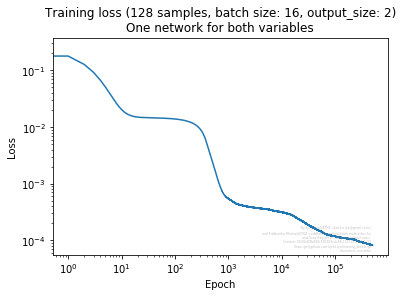

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


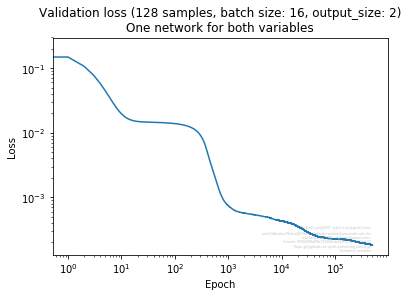

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


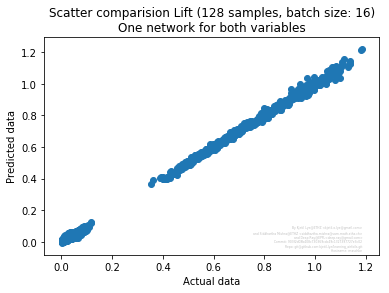

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_55 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_56 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_57 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 12)                132       
__________

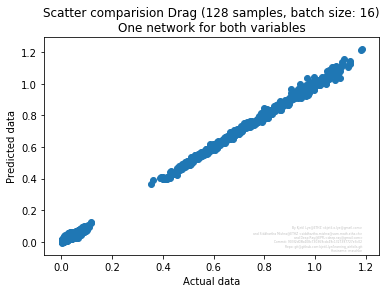

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 10)                70        
_________________________________________________________________
activation_55 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 12)                132       
_________________________________________________________________
activation_56 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 10)                130       
_________________________________________________________________
activation_57 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 12)                132       
__________

ValueError: x and y must be the same size

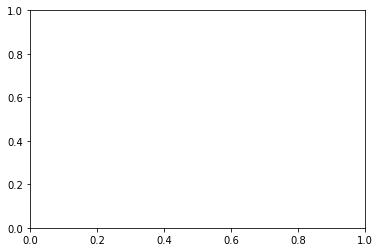

In [11]:
force_names=['Lift', 'Drag']
batch_sizes=[16, 32, train_size]

for batch_size in batch_sizes:
    
    showAndSave.prefix='airfoil_ts_%d_bs_%d_dual' %(batch_size, train_size)
    network= get_network_dual(qmc_points, forces[:,1:], train_size=train_size, validation_size=validation_size,
                        batch_size=batch_size, title="One network for both variables",names=force_names)
    
    

